The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


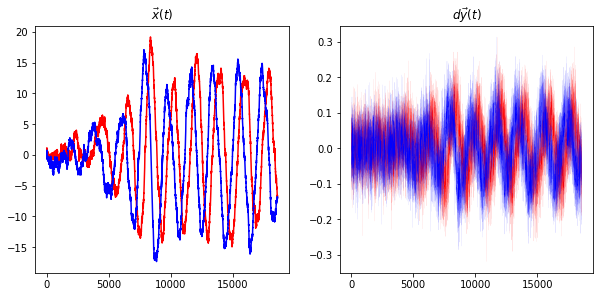

In [201]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from misc import *
import tensorflow as tf
%load_ext autoreload
%autoreload 2


means = np.load("data/means.npy").astype(np.float32) ### this is \textbf{q}(t)
covs = np.load("data/covs.npy").astype(np.float32) ## this is the \Sigma(t)
xicovs = np.load("data/xicovs.npy").astype(np.float32) ## this is the \Chi(\Sigma) (evolution)
signals = np.load("data/signals.npy").astype(np.float32) ##this is the dy's

A = np.load("data/A.npy").astype(np.float32)
dt = np.load("data/dt.npy")[0]
C = np.load("data/C.npy").astype(np.float32)
D = np.load("data/D.npy").astype(np.float32)

coeffs = [C, A, D , dt]

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title(r'$\vec{x}(t)$')
for ind, c in enumerate(["red","blue"]):
    plt.plot(np.array(means)[:,ind], color=c)
plt.subplot(222)
plt.title(r'$d\vec{y}(t)$')
for ind, c in enumerate(["red","blue"]):
    plt.plot(np.array(signals)[:,ind], color=c, linewidth=0.05)


In [202]:
def sliced_dataset(t):
    tfsignals = tf.convert_to_tensor(signals)[:t] ## this are dy's
    tfxicovs = tf.convert_to_tensor(xicovs)[:-1][:t] ### since we get (\mu_t, \Sigma_t) ---> Measurement ( = signal) ---> (\mu_{t+1}, \Sigma_{t+1})
    return (tfxicovs[tf.newaxis,:,:,:], tfsignals[tf.newaxis,:,:])

In [203]:
from RNN_models import *

model = GaussianRecuModel(coeffs)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1))

In [204]:
time_slice = len(signals)
inputs = sliced_dataset(time_slice)
model.fit(x=inputs, y=inputs[1][tf.newaxis,:,:], epochs=100, verbose=1)
    

Epoch 1/100
1/1 [==============================] - 0s 677us/step - total_loss: 0.0035
Epoch 2/100
1/1 [==============================] - 0s 658us/step - total_loss: 0.0035
Epoch 3/100
1/1 [==============================] - 0s 688us/step - total_loss: 0.0034
Epoch 4/100
1/1 [==============================] - 0s 685us/step - total_loss: 0.0034
Epoch 5/100
1/1 [==============================] - 0s 781us/step - total_loss: 0.0034
Epoch 6/100
1/1 [==============================] - 0s 766us/step - total_loss: 0.0034
Epoch 7/100
1/1 [==============================] - 0s 787us/step - total_loss: 0.0034
Epoch 8/100
1/1 [==============================] - 0s 749us/step - total_loss: 0.0034
Epoch 9/100
1/1 [==============================] - 0s 874us/step - total_loss: 0.0034
Epoch 10/100
1/1 [==============================] - 0s 926us/step - total_loss: 0.0033
Epoch 11/100
1/1 [==============================] - 0s 899us/step - total_loss: 0.0033
Epoch 12/100
1/1 [==============================] - 

1/1 [==============================] - 0s 804us/step - total_loss: 0.0033
Epoch 96/100
1/1 [==============================] - 0s 1ms/step - total_loss: 0.0033
Epoch 97/100
1/1 [==============================] - 0s 1ms/step - total_loss: 0.0033
Epoch 98/100
1/1 [==============================] - 0s 1ms/step - total_loss: 0.0033
Epoch 99/100
1/1 [==============================] - 0s 828us/step - total_loss: 0.0033
Epoch 100/100
1/1 [==============================] - 0s 889us/step - total_loss: 0.0033


In [206]:
model.trainable_variables

[<tf.Variable 'gaussian_recu_model_31/rnn_32/stacked_rnn_cells_33/gaussian_dynamics__recurrent_cell_33/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.00415921,  0.9757078 ],
        [-0.9865686 , -0.04448316]], dtype=float32)>]

In [207]:
predictions = model.recurrent_layer(sliced_dataset(len(signals)), initial_state=model.initial_state)
tfmeans = tf.convert_to_tensor(means.astype(np.float32))
Cxdt=tf.einsum('ij,kj->ki',model.C, tfmeans)*model.dt

Text(0.5, 0, 'time')

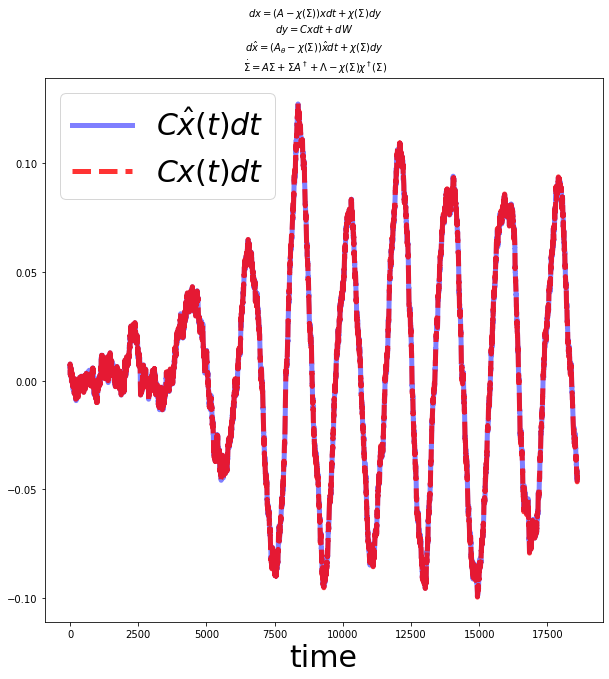

In [211]:
plt.figure(figsize=(10,10))

#plt.title("Learning stochastic time-series")
plt.suptitle(r'$ dx = (A - \chi(\Sigma))x dt + \chi(\Sigma) dy$' +
             "\n" r'$dy =  C x dt + dW$'+ "\n" +
             r'$ d\hat{x} = (A_\theta - \chi(\Sigma))\hat{x} dt + \chi(\Sigma) dy$'
            + "\n" + r'$\dot{\Sigma} = A \Sigma + \Sigma A^\dagger + \Lambda - \chi(\Sigma) \chi^\dagger(\Sigma)$', size=10)
plt.plot(predictions[0][:,0], color="blue", alpha=0.5, linewidth=5, label=r'$C \hat{x}(t) dt$')
plt.plot(Cxdt[:,0],'--', color="red", alpha=0.8,label=r'$C x(t) dt$', linewidth=5)
plt.legend(prop={"size":30})
plt.xlabel("time", size=30)